In [7]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear
from datasets import inputs, sf_inputs_discrete
from utils import get_firing_field, get_field_metrics
import configs

device = 'cpu'

# Load existing results

In [234]:
desired_sigmas = ['sigma2.5']
desired_sparsity_range = [0.1, 0.19]
desired_sigmas = ['sigma1.75']
desired_sparsity_range = [0.1, 0.2]
gamma = 0.8
model = 'rnn'

In [235]:
results_dirs = []
data_dir = f'{configs.engram_dir}03_hannah_dset/'
for sparsity in os.listdir(data_dir):
    if not os.path.isdir(f'{data_dir}{sparsity}'): continue
    sigma_dirs = os.listdir(f'{data_dir}{sparsity}')
    for desired_sigma in desired_sigmas:
        if desired_sigma in sigma_dirs:
            results_dir = f'{data_dir}{sparsity}/{desired_sigma}/{gamma}/{model}/0/'
            results_path = results_dir + 'results.p'
            with open(results_path, 'rb') as f:
                results = pickle.load(f)
            dset = results['dset']
            final_sparsity = dset.feature_maker.post_smooth_sparsity
            if final_sparsity >= desired_sparsity_range[0]:
                if final_sparsity <= desired_sparsity_range[1]:
                    results_dirs.append(results_dir)

In [236]:
print(len(results_dirs))
results_dirs

14


['/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019526315789473683/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.040368421052631574/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03573684210526316/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.031105263157894733/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.017210526315789475/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03342105263157895/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.04268421052631578/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.014894736842105263/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.038052631578947366/sigma1.75/0.8/rnn/0/',
 '/Volumes/aronov-locke

In [237]:
results_dir = '/Volumes/aronov-locker/Ching/03_td_discrete_corr/sparsity0.021526315789473685/sigma2.0/0.4/rnn_oja/0/'

In [238]:
results_path = results_dir + 'results.p'
fieldinfos_path = results_dir + 'field_infos.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
if os.path.isfile(fieldinfos_path):
    with open(fieldinfos_path, 'rb') as f:
        fieldinfos = pickle.load(f)
if 'hopfield' in results_path:
    outputs = results['outputs'].detach().numpy().squeeze()
else:
    outputs = results['outputs']
dset = results['dset']

print('Sigma:')
print(dset.feature_maker.spatial_sigma)
print('Sparsity:')
print(dset.feature_maker.post_smooth_sparsity)

Sigma:
2.0
Sparsity:
0.13070059369873271


In [239]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(outputs.shape[1]))

### Make Plots

In [8]:
from scipy import ndimage
import matplotlib.gridspec as gridspec

In [9]:
def plot_fields(results_dir):
    results_path = results_dir + 'results.p'
    fieldinfos_path = results_dir + 'field_infos.p'
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    if os.path.isfile(fieldinfos_path):
        with open(fieldinfos_path, 'rb') as f:
            fieldinfos = pickle.load(f)
    if 'hopfield' in results_path:
        outputs = results['outputs'].detach().numpy().squeeze()
    else:
        outputs = results['outputs']
    dset = results['dset']

    print('Sigma:')
    print(dset.feature_maker.spatial_sigma)
    print('Sparsity:')
    print(dset.feature_maker.post_smooth_sparsity)

    walk_xs = dset.xs
    walk_ys = dset.ys
    arena_length = int(np.sqrt(outputs.shape[1]))

    grid_x = 2; grid_y = 8;

    plt.figure(figsize = (6.4*1.5, 4.8*0.5))
    gs1 = gridspec.GridSpec(grid_x, grid_y)
    gs1.update(wspace=0.03, hspace=0.03) # set the spacing between axes. 

    neurs = np.arange(outputs.shape[1])
    np.random.shuffle(neurs)

    idx = 0
    for neur in neurs:
        ff, mask = get_firing_field(
            walk_xs, walk_ys, outputs[:,neur],
            arena_length, normalize=True
            )
        ax = plt.subplot(gs1[idx])
        plt.axis('on')
        if np.sum(fieldinfos[neur][1]) == 0: continue # Skip non-place cells
#         ff -= ff.min()
        
        ff -= np.percentile(ff, 5)
        ff[ff<0] = 0
        
        #ff *= fieldinfos[neur][1]
        ff = ff/ff.max()
        ax.imshow(ff, vmin=0., vmax=1, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])

        idx += 1
        if idx == grid_x*grid_y: break
    plt.suptitle('Simulated Place Fields')
    plt.tight_layout()
    plt.savefig('5c_fields', dpi=300)
    plt.show()

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.019526315789473683/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.11450463518275526


/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_54031/3128699961.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


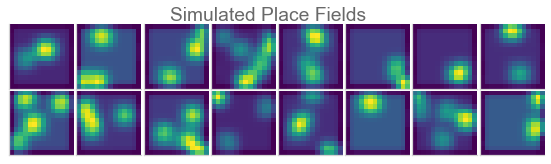

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.040368421052631574/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17451186755602688


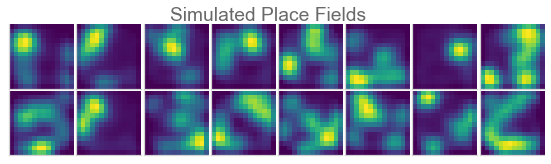

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03573684210526316/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17682959119709066


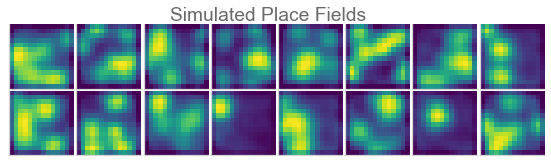

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.031105263157894733/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.15645256932293958


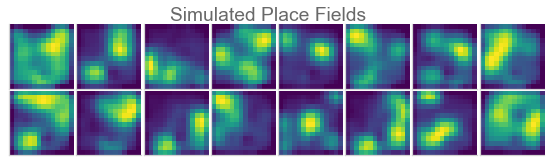

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.017210526315789475/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.11372565188224101


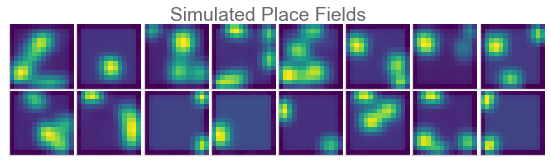

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.03342105263157895/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.16884524564099213


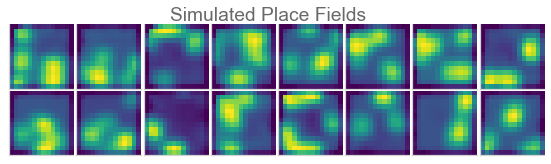

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.12176713447476092


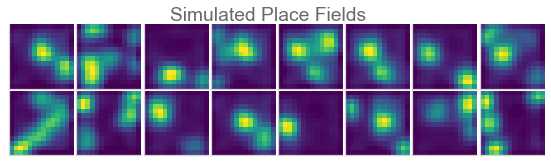

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.04268421052631578/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.18492217955872614


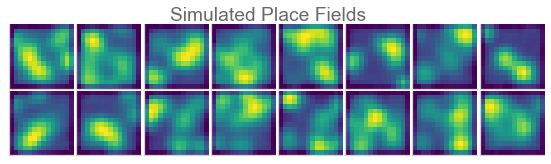

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.014894736842105263/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.10383433633244732


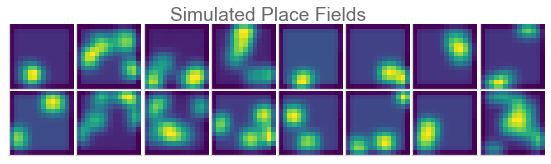

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.038052631578947366/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.17503924428650325


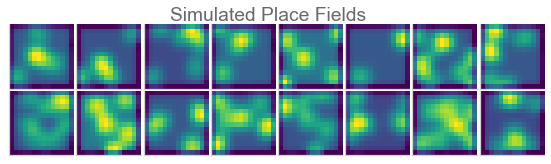

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.045/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.19141128361439264


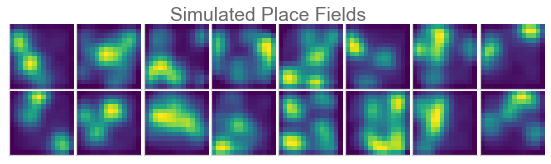

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.024157894736842104/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.1409557240768579


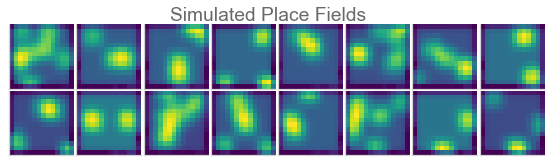

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.028789473684210524/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.16033472212810168


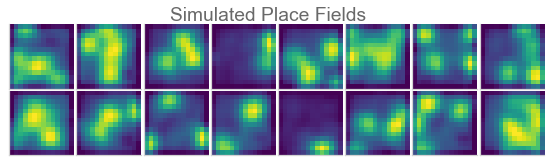

/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.026473684210526316/sigma1.75/0.8/rnn/0/
Sigma:
1.75
Sparsity:
0.14552695416512323


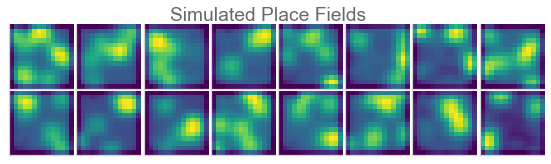

In [244]:
for x in results_dirs:
    print(x)
    plot_fields(x)

Sigma:
1.75
Sparsity:
0.1261203201515304


/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_54031/3128699961.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


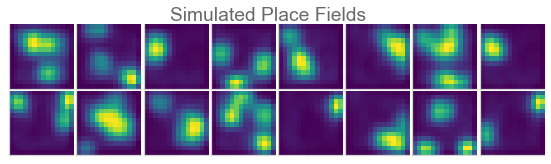

In [246]:
plot_fields('/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.75/0.8/rnn/8/')

In [12]:
plot_fields('/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.0/0.8/linear/8/')

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/aronov-locker/Ching/03_hannah_dset/sparsity0.021842105263157892/sigma1.0/0.8/linear/8/results.p'

### Metrics

In [59]:
fieldsize, nfield, onefield = get_field_metrics(outputs, dset, arena_length, nshuffles=10)

In [60]:
print(f'Fieldsize: {fieldsize}')
print(f'# Fields: {nfield}')
print(f'Ratio One Field: {onefield}')

Fieldsize: 0.05999538319482919
# Fields: 2.7075
Ratio One Field: 0.0875
